# Regression
Predict the final goals scored per each team.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow_core.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model
from keras import callbacks
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile

Using TensorFlow backend.


## Data Preprocessing
    1. Normalization
    2. Data encoding: The goals [0,10] => [-1,1]. If Goal > 10 => 1

In [2]:
df02 = pd.read_csv('../data/data_regression_goals/sliding02_goals.csv', sep=',', index_col=0)

In [3]:
df02.head()

,home_team_goal,away_team_goal,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,1,3.50,3.30,2.10,1,3,6,11,16,137,67,117,53,8,2,0,15,6,161,78,72,30
1,2,2,2.50,3.30,2.88,3,1,6,8,16,134,64,151,77,3,3,4,11,18,104,44,87,36
2,1,2,1.91,3.40,4.20,4,2,4,10,15,120,58,124,56,2,2,6,11,15,134,59,100,46
3,2,1,3.25,3.25,2.30,5,2,3,22,12,177,82,74,37,6,3,1,19,8,169,95,113,58
4,3,0,1.20,6.00,19.00,7,2,1,15,8,161,72,74,31,3,2,5,10,17,143,69,134,69


In [4]:
def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['home_team_goal','away_team_goal']).values
    y = dataframe[['home_team_goal','away_team_goal']].values
    return X,y

In [5]:
def encode(i):
    # 1 be assigned as default value of passed argument (if goals > 10)
    return i

def decode(i):
    return i

In [6]:
def normalize(dataframe):
    column_names_to_not_normalize = ['home_team_goal','away_team_goal']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    x_scaled = preprocessing.normalize(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp
    
    dataframe['home_team_goal'] = dataframe.apply(lambda row: encode(row['home_team_goal']), axis=1)
    dataframe['away_team_goal'] = dataframe.apply(lambda row: encode(row['away_team_goal']), axis=1)
    
    return dataframe

In [7]:
n02 = normalize(df02)

train, test = train_test_split(n02, test_size=0.1, shuffle=False)
print(len(train), 'train examples')
print(len(test), 'test examples')


train_X,train_y = get_X_and_y(train)

test_X,test_y = get_X_and_y(test)

6329 train examples
704 test examples


In [8]:
n02.head()

,home_team_goal,away_team_goal,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2.0,1.0,0.012482,0.011769,0.007489,0.003566,0.010699,0.021398,0.039230,0.057061,0.488587,0.238944,0.417260,0.189015,0.028531,0.007133,0.000000,0.053495,0.021398,0.574178,0.278173,0.256775,0.106990
1,2.0,2.0,0.009236,0.012191,0.010640,0.011083,0.003694,0.022166,0.029555,0.059110,0.495044,0.236439,0.557848,0.284465,0.011083,0.011083,0.014777,0.040638,0.066498,0.384213,0.162552,0.321409,0.132997
2,1.0,2.0,0.007188,0.012795,0.015805,0.015053,0.007526,0.015053,0.037632,0.056448,0.451585,0.218266,0.466638,0.210740,0.007526,0.007526,0.022579,0.041395,0.056448,0.504270,0.222029,0.376321,0.173108
3,2.0,1.0,0.010289,0.010289,0.007281,0.015829,0.006332,0.009497,0.069647,0.037989,0.560339,0.259592,0.234266,0.117133,0.018995,0.009497,0.003166,0.060149,0.025326,0.535013,0.300747,0.357730,0.183614
4,3.0,0.0,0.004077,0.020384,0.064551,0.023782,0.006795,0.003397,0.050961,0.027179,0.546982,0.244613,0.251408,0.105320,0.010192,0.006795,0.016987,0.033974,0.057756,0.485829,0.234421,0.455252,0.234421


In [9]:
train, val = train_test_split(train, test_size=0.2)

In [10]:
#create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels2 = dataframe.pop('home_team_goal')
  labels = dataframe.pop('away_team_goal')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [11]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [12]:
feature_columns = []
for header in ['odds-home', 'odds-draw', 'odds-away', 'home-draws', 'home-losses', 'home-goals','home-opposition-goals',
               'home-shots','home-shots_on_target','home-opposition_shots_on_target','home-wins','away-wins','away-draws','away-losses',
              'away-goals','away-opposition-goals','away-shots','away-shots_on_target','away-opposition_shots','away-opposition_shots_on_target']:
  feature_columns.append(feature_column.numeric_column(header))

In [13]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [14]:
batch_size = 128
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [15]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(11, activation='softmax')
])

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = callbacks.ModelCheckpoint(filepath="resultsDN/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=False, monitor='val_acc',mode='max')
csv_logger = CSVLogger('resultsDN/trainanalysis1.csv',separator=',', append=False)


history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=150,
          callbacks=[checkpointer,csv_logger])

model.save("resultsDN/cnn_model.hdf5")

Train for 40 steps, validate for 10 steps
Epoch 1/150
34/40 [========================>.....] - ETA: 0s - loss: 1.8360 - accuracy: 0.3297
Epoch 00001: saving model to resultsDN/checkpoint-01.hdf5
40/40 [==============================] - 1s 30ms/step - loss: 1.7782 - accuracy: 0.3312 - val_loss: 1.4739 - val_accuracy: 0.3373
Epoch 2/150
32/40 [=======================>......] - ETA: 0s - loss: 1.4329 - accuracy: 0.3330
Epoch 00002: saving model to resultsDN/checkpoint-02.hdf5
40/40 [==============================] - 0s 8ms/step - loss: 1.4371 - accuracy: 0.3346 - val_loss: 1.4457 - val_accuracy: 0.3381
Epoch 3/150
29/40 [====================>.........] - ETA: 0s - loss: 1.4257 - accuracy: 0.3435
Epoch 00003: saving model to resultsDN/checkpoint-03.hdf5
40/40 [==============================] - 0s 9ms/step - loss: 1.4192 - accuracy: 0.3441 - val_loss: 1.4351 - val_accuracy: 0.3254
Epoch 4/150
36/40 [==========================>...] - ETA: 0s - loss: 1.4118 - accuracy: 0.3444
Epoch 00004: sav

Epoch 30/150
34/40 [========================>.....] - ETA: 0s - loss: 1.3826 - accuracy: 0.3711
Epoch 00030: saving model to resultsDN/checkpoint-30.hdf5
40/40 [==============================] - 0s 11ms/step - loss: 1.3838 - accuracy: 0.3711 - val_loss: 1.4172 - val_accuracy: 0.3578
Epoch 31/150
32/40 [=======================>......] - ETA: 0s - loss: 1.3846 - accuracy: 0.3772
Epoch 00031: saving model to resultsDN/checkpoint-31.hdf5
40/40 [==============================] - 0s 7ms/step - loss: 1.3794 - accuracy: 0.3711 - val_loss: 1.3984 - val_accuracy: 0.3776
Epoch 32/150
33/40 [=======================>......] - ETA: 0s - loss: 1.3802 - accuracy: 0.3714
Epoch 00032: saving model to resultsDN/checkpoint-32.hdf5
40/40 [==============================] - 0s 7ms/step - loss: 1.3796 - accuracy: 0.3682 - val_loss: 1.3979 - val_accuracy: 0.3799
Epoch 33/150
27/40 [===================>..........] - ETA: 0s - loss: 1.3825 - accuracy: 0.3799
Epoch 00033: saving model to resultsDN/checkpoint-33.h

Epoch 59/150
39/40 [============================>.] - ETA: 0s - loss: 1.3725 - accuracy: 0.3708
Epoch 00059: saving model to resultsDN/checkpoint-59.hdf5
40/40 [==============================] - 0s 11ms/step - loss: 1.3712 - accuracy: 0.3709 - val_loss: 1.3981 - val_accuracy: 0.3752
Epoch 60/150
33/40 [=======================>......] - ETA: 0s - loss: 1.3708 - accuracy: 0.3712
Epoch 00060: saving model to resultsDN/checkpoint-60.hdf5
40/40 [==============================] - 0s 11ms/step - loss: 1.3714 - accuracy: 0.3735 - val_loss: 1.3953 - val_accuracy: 0.3807
Epoch 61/150
34/40 [========================>.....] - ETA: 0s - loss: 1.3731 - accuracy: 0.3801
Epoch 00061: saving model to resultsDN/checkpoint-61.hdf5
40/40 [==============================] - 0s 10ms/step - loss: 1.3696 - accuracy: 0.3788 - val_loss: 1.3978 - val_accuracy: 0.3736
Epoch 62/150
34/40 [========================>.....] - ETA: 0s - loss: 1.3669 - accuracy: 0.3789
Epoch 00062: saving model to resultsDN/checkpoint-62

Epoch 88/150
32/40 [=======================>......] - ETA: 0s - loss: 1.3694 - accuracy: 0.3767
Epoch 00088: saving model to resultsDN/checkpoint-88.hdf5
40/40 [==============================] - 0s 11ms/step - loss: 1.3676 - accuracy: 0.3769 - val_loss: 1.3965 - val_accuracy: 0.3728
Epoch 89/150
37/40 [==========================>...] - ETA: 0s - loss: 1.3623 - accuracy: 0.3807
Epoch 00089: saving model to resultsDN/checkpoint-89.hdf5
40/40 [==============================] - 0s 10ms/step - loss: 1.3623 - accuracy: 0.3802 - val_loss: 1.3938 - val_accuracy: 0.3839
Epoch 90/150
34/40 [========================>.....] - ETA: 0s - loss: 1.3630 - accuracy: 0.3766
Epoch 00090: saving model to resultsDN/checkpoint-90.hdf5
40/40 [==============================] - 0s 10ms/step - loss: 1.3639 - accuracy: 0.3788 - val_loss: 1.3964 - val_accuracy: 0.3736
Epoch 91/150
28/40 [====================>.........] - ETA: 0s - loss: 1.3665 - accuracy: 0.3781
Epoch 00091: saving model to resultsDN/checkpoint-91

Epoch 117/150
38/40 [===========================>..] - ETA: 0s - loss: 1.3626 - accuracy: 0.3830
Epoch 00117: saving model to resultsDN/checkpoint-117.hdf5
40/40 [==============================] - 0s 10ms/step - loss: 1.3566 - accuracy: 0.3851 - val_loss: 1.4007 - val_accuracy: 0.3689
Epoch 118/150
38/40 [===========================>..] - ETA: 0s - loss: 1.3610 - accuracy: 0.3890
Epoch 00118: saving model to resultsDN/checkpoint-118.hdf5
40/40 [==============================] - 0s 10ms/step - loss: 1.3591 - accuracy: 0.3883 - val_loss: 1.4065 - val_accuracy: 0.3633
Epoch 119/150
39/40 [============================>.] - ETA: 0s - loss: 1.3588 - accuracy: 0.3846
Epoch 00119: saving model to resultsDN/checkpoint-119.hdf5
40/40 [==============================] - 0s 10ms/step - loss: 1.3583 - accuracy: 0.3848 - val_loss: 1.3998 - val_accuracy: 0.3633
Epoch 120/150
38/40 [===========================>..] - ETA: 0s - loss: 1.3553 - accuracy: 0.3824
Epoch 00120: saving model to resultsDN/checkp

Epoch 146/150
28/40 [====================>.........] - ETA: 0s - loss: 1.3469 - accuracy: 0.3895
Epoch 00146: saving model to resultsDN/checkpoint-146.hdf5
40/40 [==============================] - 0s 9ms/step - loss: 1.3486 - accuracy: 0.3879 - val_loss: 1.3989 - val_accuracy: 0.3673
Epoch 147/150
27/40 [===================>..........] - ETA: 0s - loss: 1.3475 - accuracy: 0.3909
Epoch 00147: saving model to resultsDN/checkpoint-147.hdf5
40/40 [==============================] - 0s 9ms/step - loss: 1.3512 - accuracy: 0.3859 - val_loss: 1.4021 - val_accuracy: 0.3736
Epoch 148/150
39/40 [============================>.] - ETA: 0s - loss: 1.3555 - accuracy: 0.3888
Epoch 00148: saving model to resultsDN/checkpoint-148.hdf5
40/40 [==============================] - 0s 9ms/step - loss: 1.3588 - accuracy: 0.3875 - val_loss: 1.4001 - val_accuracy: 0.3665
Epoch 149/150
28/40 [====================>.........] - ETA: 0s - loss: 1.3547 - accuracy: 0.3881
Epoch 00149: saving model to resultsDN/checkpoin

In [17]:
model.load_weights("resultsDN/checkpoint-150.hdf5")

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

6/6 [==============================] - 0s 56ms/step - loss: 1.3761 - accuracy: 0.3480
Accuracy 0.34801137


In [19]:
model.predict(test_ds)

array([[6.19043291e-01, 2.86044866e-01, 8.09374377e-02, ...,
        8.71857545e-13, 7.14575100e-12, 2.43696816e-11],
       [3.82422805e-01, 3.07870567e-01, 2.29411781e-01, ...,
        6.48511616e-07, 4.78159734e-07, 1.07199423e-06],
       [1.20469555e-01, 3.04615796e-01, 2.97050118e-01, ...,
        3.45264561e-04, 5.16032287e-06, 9.43915802e-06],
       ...,
       [3.94259930e-01, 3.54208171e-01, 1.59643352e-01, ...,
        8.81877668e-07, 3.24315351e-06, 7.82490861e-06],
       [4.63178247e-01, 3.57151955e-01, 1.29154310e-01, ...,
        3.27012408e-08, 1.65167961e-07, 3.96315556e-07],
       [3.91346961e-01, 3.43250692e-01, 1.84084311e-01, ...,
        6.06965671e-07, 1.18015021e-06, 2.32152456e-06]], dtype=float32)

In [20]:
y_pred = model.predict(test_ds)
#accuracy = accuracy_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred , average="weighted")
#precision = precision_score(y_test, y_pred , average="weighted")
#f1 = f1_score(y_test, y_pred, average="weighted")
#np.savetxt('resultsDN/expected1.txt', y_test, fmt='%01d')
np.savetxt('resultsDN/predicted1.txt', y_pred, fmt='%01d')

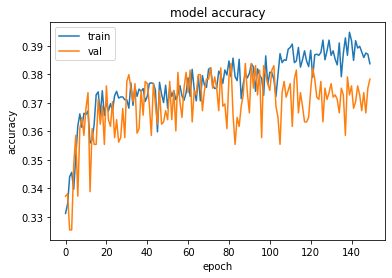

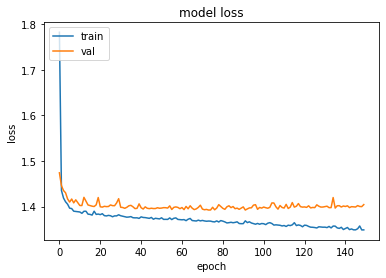

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()